<a href="https://colab.research.google.com/github/Ritukuklani/Deep-Learning/blob/main/Reptile_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reptile Meta-learning Algorithm

Original paper: http://arxiv.org/abs/1803.02999

Like MAML (Model-Agnostic Meta Learning), Reptile seeks an initialization for the parameters of a parameterized model (e.g. neural network), such that the model can be fine-tuned using a small amount of data from a new task. However, while MAML unrolls and differentiates through the computation graph of the gradient descent algorithm, Reptile simply performs stochastic gradient descent (SGD) on each task and does not unroll a computation graph or calculate any second derivatives.

### Algorithm:

```
Phi = initial parameter vector

for iteration in range(1, 2, 3, ...):
    Randomly sample a task T

    Perform k > 1 steps of SGD on task T, starting with parameters Phi, \
    resulting in parameters W

    Phi = Phi + epsilon(W - Phi)

return Phi
```

If $k = 1$ (one SGD step), this algorithm would correspond to “joint training” by performing SGD on the mixture of all tasks. Reptile requires $k > 1$ so that the update will depend on higher-order derivatives of the loss function. This corresponds to the Reptile update maximizing the inner product between gradients of different minibatches from the same task, leading to improved generalization.

# Two explanations for why Reptile works

## Taylor series expansion

The first explanation provided in the Reptile paper puts the method in direct comparison with MAML, showing that both algorithms use the same gradient terms but with different coefficients.

The gradient can be decomposed into the sum of two terms. The first term updates the parameters towards the minimum of the expected loss over tasks (joint training). Then the higher-order term enables faster learning by trying to maximize the inner product between gradients within a given task. This causes the weight updates to be chosen such that the gradients of minibatches of the same task are maximally aligned, because if the gradients from different batches have positive inner product, then taking a gradient step on one batch improves performance on the other batch.

A full derivation can be found in [the original paper](https://http://arxiv.org/abs/1803.02999).

## Minimum distance to solution manifolds

This second explanation is specific to Reptile and is somewhat more intuitive. Let $\phi$ denote the initial parameters, and $W_\tau$ denote the set of optimal parameters for task $\tau$. We will think of these as points in the space of possible parameter vectors. 

We want to find the point $\phi$ in parameter space such that the distance $D(\phi, W_\tau)$ - the distance between the network initialization point and the optimal set of parameters for task tau - is minimized for all tasks. 

$$
min_{\phi} \mathbb{E}_{\tau}\left[\frac{1}{2}D(\phi, W_{\tau})^{2}\right]
$$

We can show that Reptile corresponds to performing SGD on that objective.

The gradient of the squared distance between a point and a set is proportional to the difference between the point and the projection of that point onto the set - the projection being the closest point in the set to the projected point. 

$$
\nabla\phi \mathbb{E}_\tau \left[\frac{1}{2} D(\phi, W_\tau)^2\right] \\ = \mathbb{E}_\tau \left[\frac{1}{2}\nabla\phi D(\phi, W_\tau)^2 \right] \\ = \mathbb{E}_\tau \left[\phi − P_{W_\tau}(\phi)\right]
$$

The projection $P_{W_\tau}(\phi)$ onto the set of optimal parameters for task $\tau$ is the argmin over points $p$ of the distance between $p$ and $\phi$: $P_{W_\tau}(\phi) = \arg\min_{p\in W_\tau} D(p, \phi)$.

Here, the projection of $\phi$ onto $W_\tau$ is the closest point in $W_\tau$ to $\phi$. In other words, the gradient of the distance between $\phi$ and $W_\tau$ is $(\phi – projection_{W_\tau}(\phi))$ - the direction of the most direct path to $W_\tau$.

Each iteration of Reptile corresponds to sampling a task $\tau$ and performing a stochastic gradient update of this distance objective, based on that sample. Then the inner steps of stochastic gradient descent find an estimate of the projected point, i.e. the closest point to $\phi$ on the optimal solution manifold for the sampled task.

Overall, with each iteration, the point $\phi$ takes a step in the direction of the optimal parameters based on a single task, and after repeating this for many tasks we converge to a point in the parameter space which is as close as possible to optimal for all the tasks.

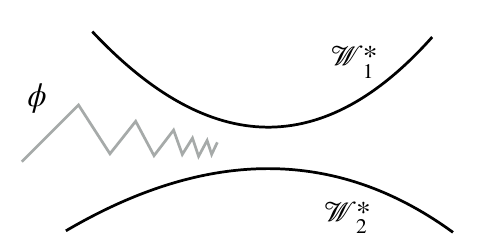

## Example of Reptile for few-shot regression

In [ ]:
import numpy as np
import torch
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
from copy import deepcopy

seed = 0
plot = True
innerstepsize = 0.02 # stepsize in inner SGD
innerepochs = 1 # number of epochs of each inner SGD
outerstepsize0 = 0.1 # stepsize of outer optimization (meta-optimization)
niterations = 30000 # number of outer updates; each iteration we sample one task and update on it

rng = np.random.RandomState(seed)
torch.manual_seed(seed)

In [ ]:
# Define the model. Tanh gives slightly better results than ReLU
model = nn.Sequential(
    nn.Linear(1, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1),
)

def totorch(x):
    return ag.Variable(torch.Tensor(x))

# Inner SGD loop
def train_on_batch(x, y):
    x = totorch(x)
    y = totorch(y)
    model.zero_grad()
    ypred = model(x)
    loss = (ypred - y).pow(2).mean() # MSE
    loss.backward()
    for param in model.parameters():
        param.data -= innerstepsize * param.grad.data

def predict(x):
    x = totorch(x)
    return model(x).data.numpy()

In [ ]:
"""
Minimal example of few-shot regression, predicting a random sine wave 
from 10 (x, y) pairs
"""
# Define task distribution
x_all = np.linspace(-5, 5, 50)[:, None] # All of the x points
ntrain = 10 # Size of training minibatches

def gen_task():
    """
    Generate random sine function
    """
    phase = rng.uniform(low=0, high=2*np.pi)
    ampl = rng.uniform(0.1, 5)
    f_randomsine = lambda x : np.sin(x + phase) * ampl
    return f_randomsine

# Choose a fixed task and minibatch for visualization
f_plot = gen_task()
xtrain_plot = x_all[rng.choice(len(x_all), size=ntrain)]

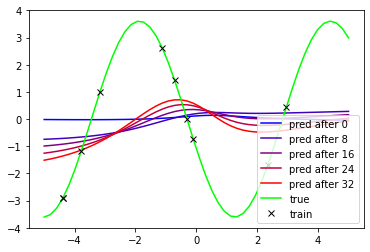

-----------------------------
iteration               1
loss on plotted curve   6.141


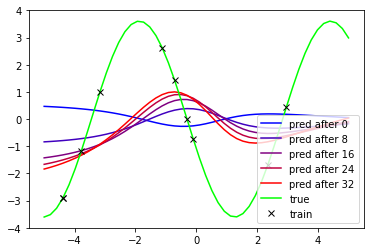

-----------------------------
iteration               1000
loss on plotted curve   5.604


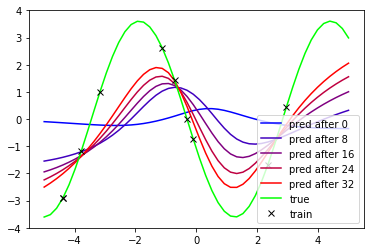

-----------------------------
iteration               2000
loss on plotted curve   1.760


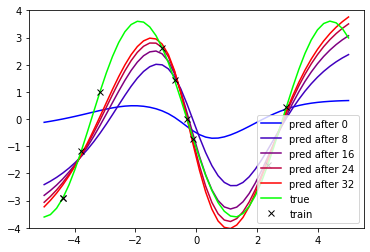

-----------------------------
iteration               3000
loss on plotted curve   0.334


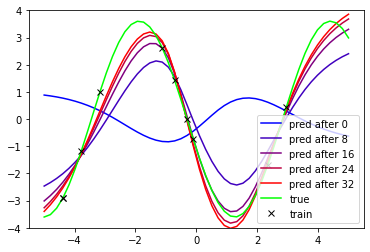

-----------------------------
iteration               4000
loss on plotted curve   0.210


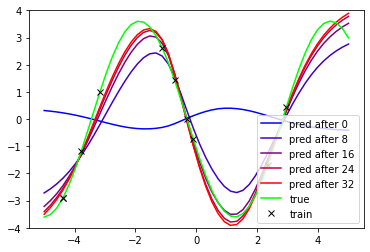

-----------------------------
iteration               5000
loss on plotted curve   0.144


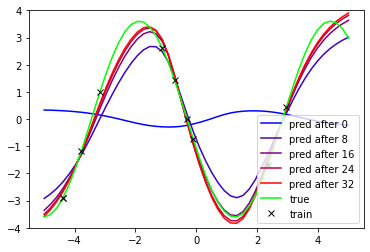

-----------------------------
iteration               6000
loss on plotted curve   0.103


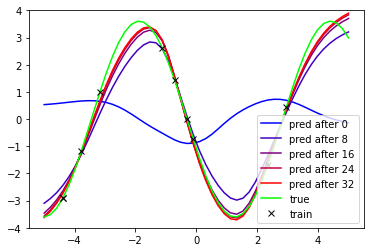

-----------------------------
iteration               7000
loss on plotted curve   0.082


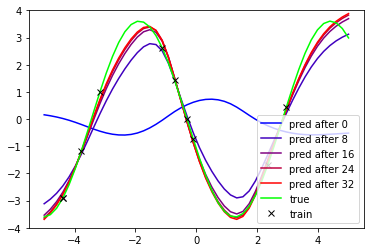

-----------------------------
iteration               8000
loss on plotted curve   0.078


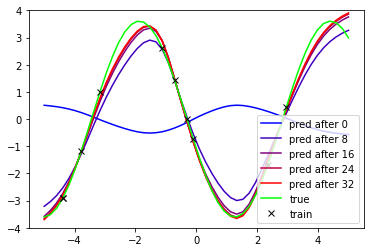

-----------------------------
iteration               9000
loss on plotted curve   0.069


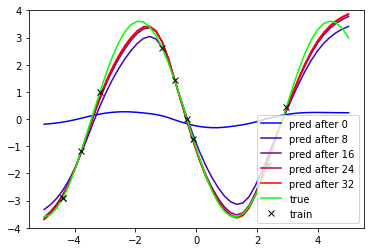

-----------------------------
iteration               10000
loss on plotted curve   0.061


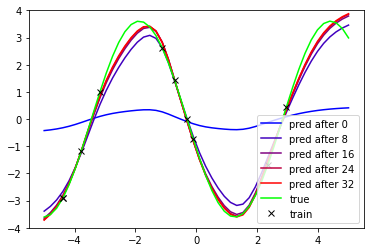

-----------------------------
iteration               11000
loss on plotted curve   0.063


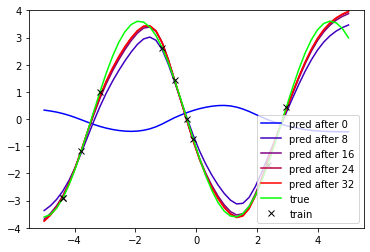

-----------------------------
iteration               12000
loss on plotted curve   0.064


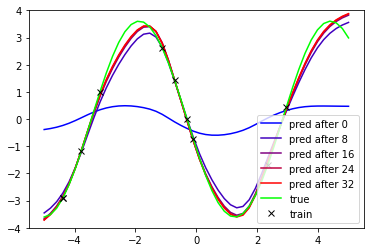

-----------------------------
iteration               13000
loss on plotted curve   0.056


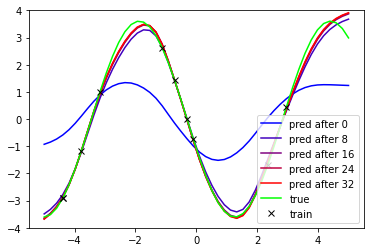

-----------------------------
iteration               14000
loss on plotted curve   0.042


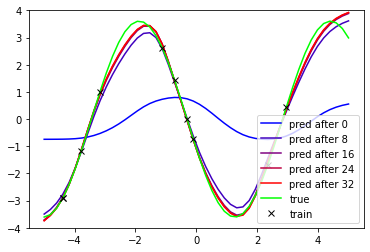

-----------------------------
iteration               15000
loss on plotted curve   0.055


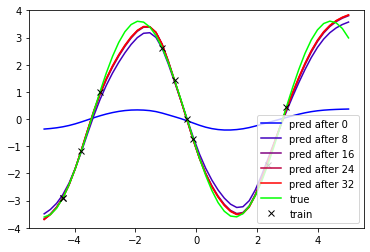

-----------------------------
iteration               16000
loss on plotted curve   0.055


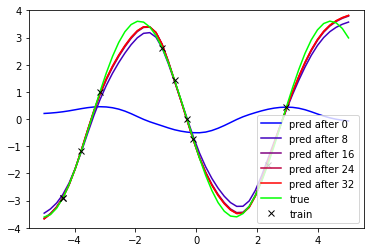

-----------------------------
iteration               17000
loss on plotted curve   0.054


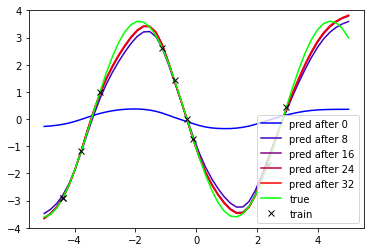

-----------------------------
iteration               18000
loss on plotted curve   0.058


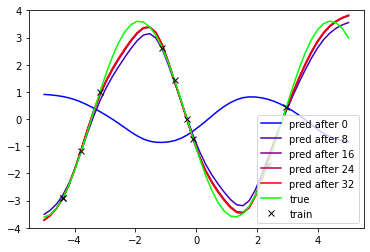

-----------------------------
iteration               19000
loss on plotted curve   0.075


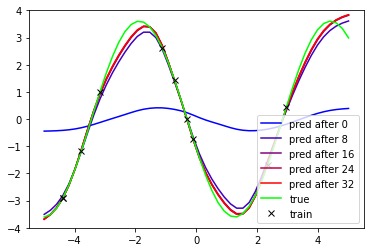

-----------------------------
iteration               20000
loss on plotted curve   0.054


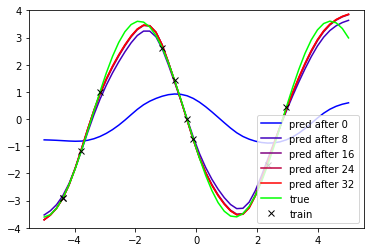

-----------------------------
iteration               21000
loss on plotted curve   0.055


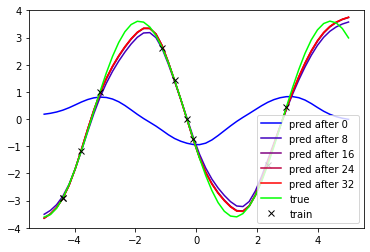

-----------------------------
iteration               22000
loss on plotted curve   0.062


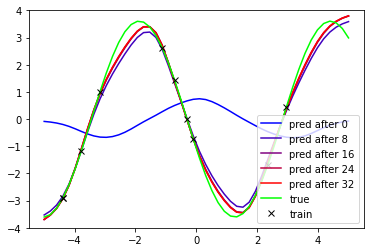

-----------------------------
iteration               23000
loss on plotted curve   0.069


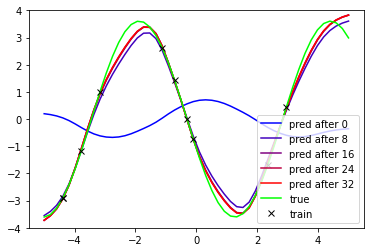

-----------------------------
iteration               24000
loss on plotted curve   0.065


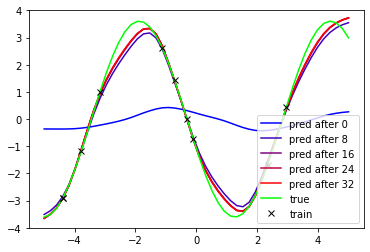

-----------------------------
iteration               25000
loss on plotted curve   0.076


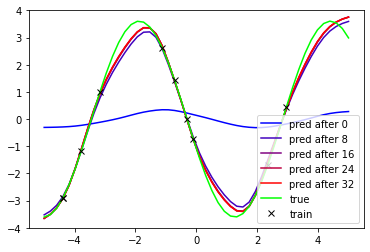

-----------------------------
iteration               26000
loss on plotted curve   0.068


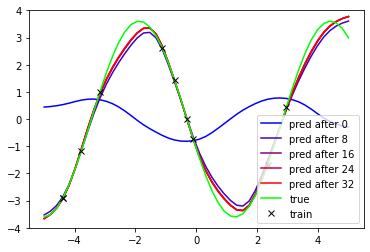

-----------------------------
iteration               27000
loss on plotted curve   0.071


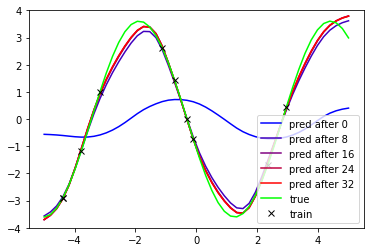

-----------------------------
iteration               28000
loss on plotted curve   0.061


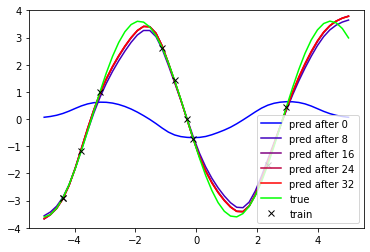

-----------------------------
iteration               29000
loss on plotted curve   0.062


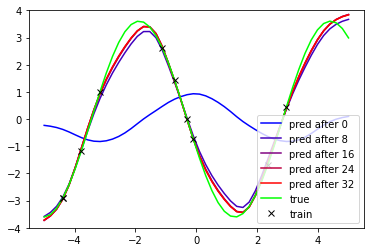

-----------------------------
iteration               30000
loss on plotted curve   0.067


In [ ]:
# Reptile training loop

for iteration in range(niterations):
    # Save initial weights in state_dict
    weights_before = deepcopy(model.state_dict())

    # Generate the task
    f = gen_task()
    y_all = f(x_all)

    # Do SGD on the task
    inds = rng.permutation(len(x_all)) # i.e. shuffle
    for _ in range(innerepochs):
        # iterate over minibatches using intervals of the random indices
        for start in range(0, len(x_all), ntrain):
            mbinds = inds[start:start+ntrain]
            train_on_batch(x_all[mbinds], y_all[mbinds])

    # Interpolate between current weights and trained weights from this task
    # (weights_before - weights_after) is the meta-gradient
    weights_after = model.state_dict()
    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule

    model.load_state_dict({name : 
        weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize 
        for name in weights_before})

    # Periodically plot the results on a particular task and minibatch
    if plot and iteration==0 or (iteration+1) % 1000 == 0:
        plt.cla()
        f = f_plot
        weights_before = deepcopy(model.state_dict()) # save snapshot before evaluation
        plt.plot(x_all, predict(x_all), label="pred after 0", color=(0,0,1))
        for inneriter in range(32):
            train_on_batch(xtrain_plot, f(xtrain_plot))
            if (inneriter + 1) % 8 == 0:
                frac = (inneriter + 1) / 32
                plt.plot(x_all, predict(x_all), label="pred after %i"%(inneriter+1), color=(frac, 0, 1-frac))
        plt.plot(x_all, f(x_all), label="true", color=(0,1,0))
        lossval = np.square(predict(x_all) - f(x_all)).mean()
        plt.plot(xtrain_plot, f(xtrain_plot), "x", label="train", color="k")
        plt.ylim(-4,4)
        plt.legend(loc="lower right")
        plt.pause(0.01)
        model.load_state_dict(weights_before) # restore from snapshot
        print(f"-----------------------------")
        print(f"iteration               {iteration+1}")
        print(f"loss on plotted curve   {lossval:.3f}")